<a href="https://colab.research.google.com/github/hatimdeve/python/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-503bc0bb-03d5-fc8f-0d52-a6556f0c4da5)


In [ ]:
!pip install tensorflow==2.13.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.* (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.13.*


In [ ]:
# Note: As of May 2023, there have been some issues with TensorFlow versions 2.9-2.12
# with the following code. 
# However, these seemed to have been fixed in version 2.13+.
# TensorFlow version 2.13 is available in tf-nightly as of May 2023 (will be default in Google Colab soon).
# Therefore, to prevent errors we'll install tf-nightly first.
# See more here: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/550 

# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 28.0 MB/s eta 0:00:00
TensorFlow version: 2.14.0-dev20230531
Notebook last run (end-to-end): 2023-05-31 16:52:20.671446


In [ ]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-05-31 16:52:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-31 16:52:20 (89.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
from google.colab import drive
drive.mount("/content/Drive")

Mounted at /content/Drive


In [ ]:
path = "/content/Drive/MyDrive/my_dataset/"

In [ ]:
# Create training and test directories
train_dir = "/content/Drive/MyDrive/my_dataset/CNN_project/train/"
test_dir = "/content/Drive/MyDrive/my_dataset/CNN_project/test/"

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           shuffle=False)




Found 12447 files belonging to 67 classes.
Found 3144 files belonging to 67 classes.


In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 67), dtype=tf.float32, name=None))>

In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers


## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = tf.keras.models.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## OLD
# # Setup data augmentation
# from tensorflow.keras.layers.experimental import preprocessing
# data_augmentation = Sequential([
#   preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
#   preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
#   preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
#   preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
#   preprocessing.RandomZoom(0.2), # randomly zoom into an image
#   # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 


In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)


<Policy "mixed_float16">

In [ ]:

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(train_data.class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 67)                137283    
                                                                 
 softmax_float32 (Activatio  (None, 67)                0         
 n)                                                              
                                                             

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
resnet50 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
conv1_pad False float32 <Policy "mixed_float16">
conv1_conv False float32 <Policy "mixed_float16">
conv1_bn False float32 <Policy "mixed_float16">
conv1_relu False float32 <Policy "mixed_float16">
pool1_pad False float32 <Policy "mixed_float16">
pool1_pool False float32 <Policy "mixed_float16">
conv2_block1_1_conv False float32 <Policy "mixed_float16">
conv2_block1_1_bn False float32 <Policy "mixed_float16">
conv2_block1_1_relu False float32 <Policy "mixed_float16">
conv2_block1_2_conv False float32 <Policy "mixed_float16">
conv2_block1_2_bn False float32 <Policy "mixed_float16">
conv2_block1_2_relu False float32 <Policy "mixed_float16">
conv2_block1_0_conv False float32 <Policy "mixed_float16">
conv2_block1_3_conv False float32 <Policy "mixed_float16">
conv2_block1_0_bn False float32 <Policy "mixed_float16">
conv2_block1_3_bn False float32 <Policy "mixed_float16">
conv2_block1_add False float32 <Policy "mixed_float16">
conv2_block1_out False fl

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230531-165325
Epoch 1/3
389/389 [==============================] - 1494s 4s/step - loss: 1.8161 - accuracy: 0.5237 - val_loss: 1.4710 - val_accuracy: 0.5871
Epoch 2/3
389/389 [==============================] - 56s 142ms/step - loss: 0.9204 - accuracy: 0.7334 - val_loss: 1.4479 - val_accuracy: 0.6004
Epoch 3/3
389/389 [==============================] - 57s 145ms/step - loss: 0.6736 - accuracy: 0.7988 - val_loss: 1.3923 - val_accuracy: 0.6339


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

99/99 [==============================] - 270s 3s/step - loss: 1.2537 - accuracy: 0.6673


[1.25371253490448, 0.6673027873039246]

In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model 
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(train_data.class_names))(x) # want one output neuron per class 
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
  model = tf.keras.Model(inputs, outputs)
  
  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

99/99 [==============================] - 16s 132ms/step - loss: 1.2537 - accuracy: 0.6673


In [ ]:
# Are any of the layers in our model frozen?
for layer in created_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
resnet50 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230531-172529
Epoch 1/100
389/389 [==============================] - 61s 140ms/step - loss: 0.4074 - accuracy: 0.8931 - val_loss: 1.2286 - val_accuracy: 0.6629 - lr: 1.0000e-04
Epoch 2/100
389/389 [==============================] - 54s 137ms/step - loss: 0.3804 - accuracy: 0.9054 - val_loss: 1.2390 - val_accuracy: 0.6585 - lr: 1.0000e-04
Epoch 3/100
389/389 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.9144
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
389/389 [==============================] - 55s 138ms/step - loss: 0.3622 - accuracy: 0.9144 - val_loss: 1.2362 - val_accuracy: 0.6540 - lr: 1.0000e-04
Epoch 4/100
389/389 [==============================] - 55s 139ms/step - loss: 0.3379 - accuracy: 0.9234 - val_loss: 1.2180 - val_accuracy: 0.6562 - lr: 2.0000e-05
Epoch 5/100
389/389 [==============================] - 54s 138ms/step - loss: 

In [ ]:
# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = model.evaluate(test_data)

99/99 [==============================] - 14s 138ms/step - loss: 1.0742 - accuracy: 0.6978


In [ ]:
results_created_model_with_loaded_weights

[1.0741565227508545, 0.6978371739387512]

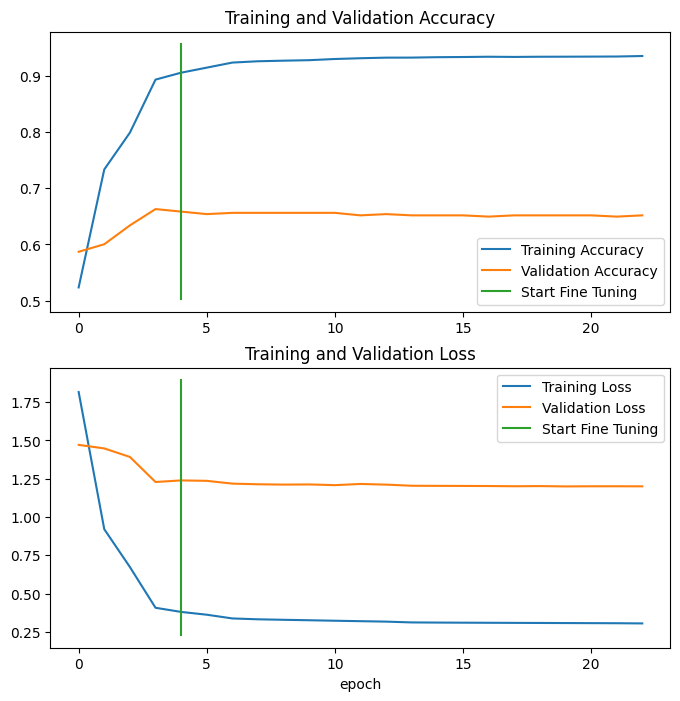

In [ ]:
compare_historys(original_history=history_classes_feature_extract,
                 new_history=history_101_food_classes_all_data_fine_tune,
                 initial_epochs=5)

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

99/99 [==============================] - 15s 138ms/step


In [ ]:
# How many predictions are there?
len(pred_probs)

3144

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(3144, 67)

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 67
What prediction probability sample 0 looks like:
 [9.86147225e-01 3.56142806e-07 1.20481559e-06 2.16011543e-07
 5.29359063e-08 1.75933206e-08 8.11798362e-09 6.48584262e-08
 6.58797958e-08 1.06708891e-08 1.30271633e-06 2.38960258e-11
 1.21426524e-06 1.65175284e-12 7.23764060e-06 1.11763192e-12
 1.27369510e-13 1.11126828e-11 1.35461062e-06 5.44195836e-06
 1.64332903e-07 6.45862752e-10 5.29359063e-08 2.31746554e-07
 1.08781054e-10 2.56906468e-10 4.52784761e-08 5.37695222e-08
 5.07246341e-06 4.43894560e-10 6.83602730e-09 2.69235662e-10
 7.28787516e-12 8.72765540e-08 2.23337543e-06 1.81136706e-09
 4.02474712e-12 1.96267678e-08 2.74051071e-09 5.91785522e-07
 4.29590244e-07 3.82889584e-06 2.39606197e-06 3.15430859e-09
 6.15543395e-05 2.60012420e-08 8.02580189e-07 3.88276298e-04
 3.96234911e-12 1.08161669e-09 6.83602730e-09 8.37567615e-09
 6.66762708e-06 3.62512606e-06 8.15219039e-07 3.33862573e-08
 5.25239550e-08 4.85036508e-05 7.10834458e-0

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0, 59, 59,  0, 43,  0,  0,  0,  0,  0])

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

3144

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6978371501272265

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['airport_inside',
 'artstudio',
 'auditorium',
 'bakery',
 'bar',
 'bathroom',
 'bedroom',
 'bookstore',
 'bowling',
 'buffet']

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63       122
           1       0.46      0.46      0.46        28
           2       0.85      0.47      0.61        36
           3       0.63      0.64      0.63        81
           4       0.64      0.73      0.68       121
           5       0.71      0.80      0.75        40
           6       0.70      0.67      0.68       133
           7       0.60      0.76      0.67        76
           8       0.84      0.86      0.85        43
           9       0.94      0.77      0.85        22
          10       0.79      0.85      0.82       103
          11       0.52      0.52      0.52        23
          12       0.81      0.83      0.82        36
          13       0.80      0.87      0.83        23
          14       0.88      0.88      0.88        24
          15       0.86      0.93      0.89        27
          16       0.67      0.64      0.65        22
          17       0.70    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6363636363636364,
  'recall': 0.6311475409836066,
  'f1-score': 0.6337448559670782,
  'support': 122},
 '1': {'precision': 0.4642857142857143,
  'recall': 0.4642857142857143,
  'f1-score': 0.4642857142857143,
  'support': 28},
 '2': {'precision': 0.85,
  'recall': 0.4722222222222222,
  'f1-score': 0.6071428571428571,
  'support': 36},
 '3': {'precision': 0.6265060240963856,
  'recall': 0.6419753086419753,
  'f1-score': 0.6341463414634146,
  'support': 81},
 '4': {'precision': 0.6376811594202898,
  'recall': 0.7272727272727273,
  'f1-score': 0.6795366795366795,
  'support': 121},
 '5': {'precision': 0.7111111111111111,
  'recall': 0.8,
  'f1-score': 0.7529411764705882,
  'support': 40},
 '6': {'precision': 0.7007874015748031,
  'recall': 0.6691729323308271,
  'f1-score': 0.6846153846153846,
  'support': 133},
 '7': {'precision': 0.5979381443298969,
  'recall': 0.7631578947368421,
  'f1-score': 0.6705202312138728,
  'support': 76},
 '8': {'precision': 0.840909090909

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'airport_inside': 0.6337448559670782,
 'artstudio': 0.4642857142857143,
 'auditorium': 0.6071428571428571,
 'bakery': 0.6341463414634146,
 'bar': 0.6795366795366795,
 'bathroom': 0.7529411764705882,
 'bedroom': 0.6846153846153846,
 'bookstore': 0.6705202312138728,
 'bowling': 0.8505747126436781,
 'buffet': 0.85,
 'casino': 0.8186046511627907,
 'children_room': 0.5217391304347826,
 'church_inside': 0.8219178082191781,
 'classroom': 0.8333333333333333,
 'cloister': 0.875,
 'closet': 0.8928571428571429,
 'clothingstore': 0.6511627906976744,
 'computerroom': 0.6956521739130435,
 'concert_hall': 0.7441860465116279,
 'corridor': 0.736111111111111,
 'deli': 0.32608695652173914,
 'dentaloffice': 0.7368421052631579,
 'dining_room': 0.4090909090909091,
 'elevator': 0.7222222222222222,
 'fastfood_restaurant': 0.5416666666666667,
 'florist': 0.8636363636363636,
 'gameroom': 0.5957446808510638,
 'garage': 0.5294117647058824,
 'greenhouse': 0.9,
 'grocerystore': 0.7272727272727273,
 'gym': 0.833333

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
34  inside_subway  0.908108
28     greenhouse  0.900000
15         closet  0.892857
14       cloister  0.875000
39     laundromat  0.873786

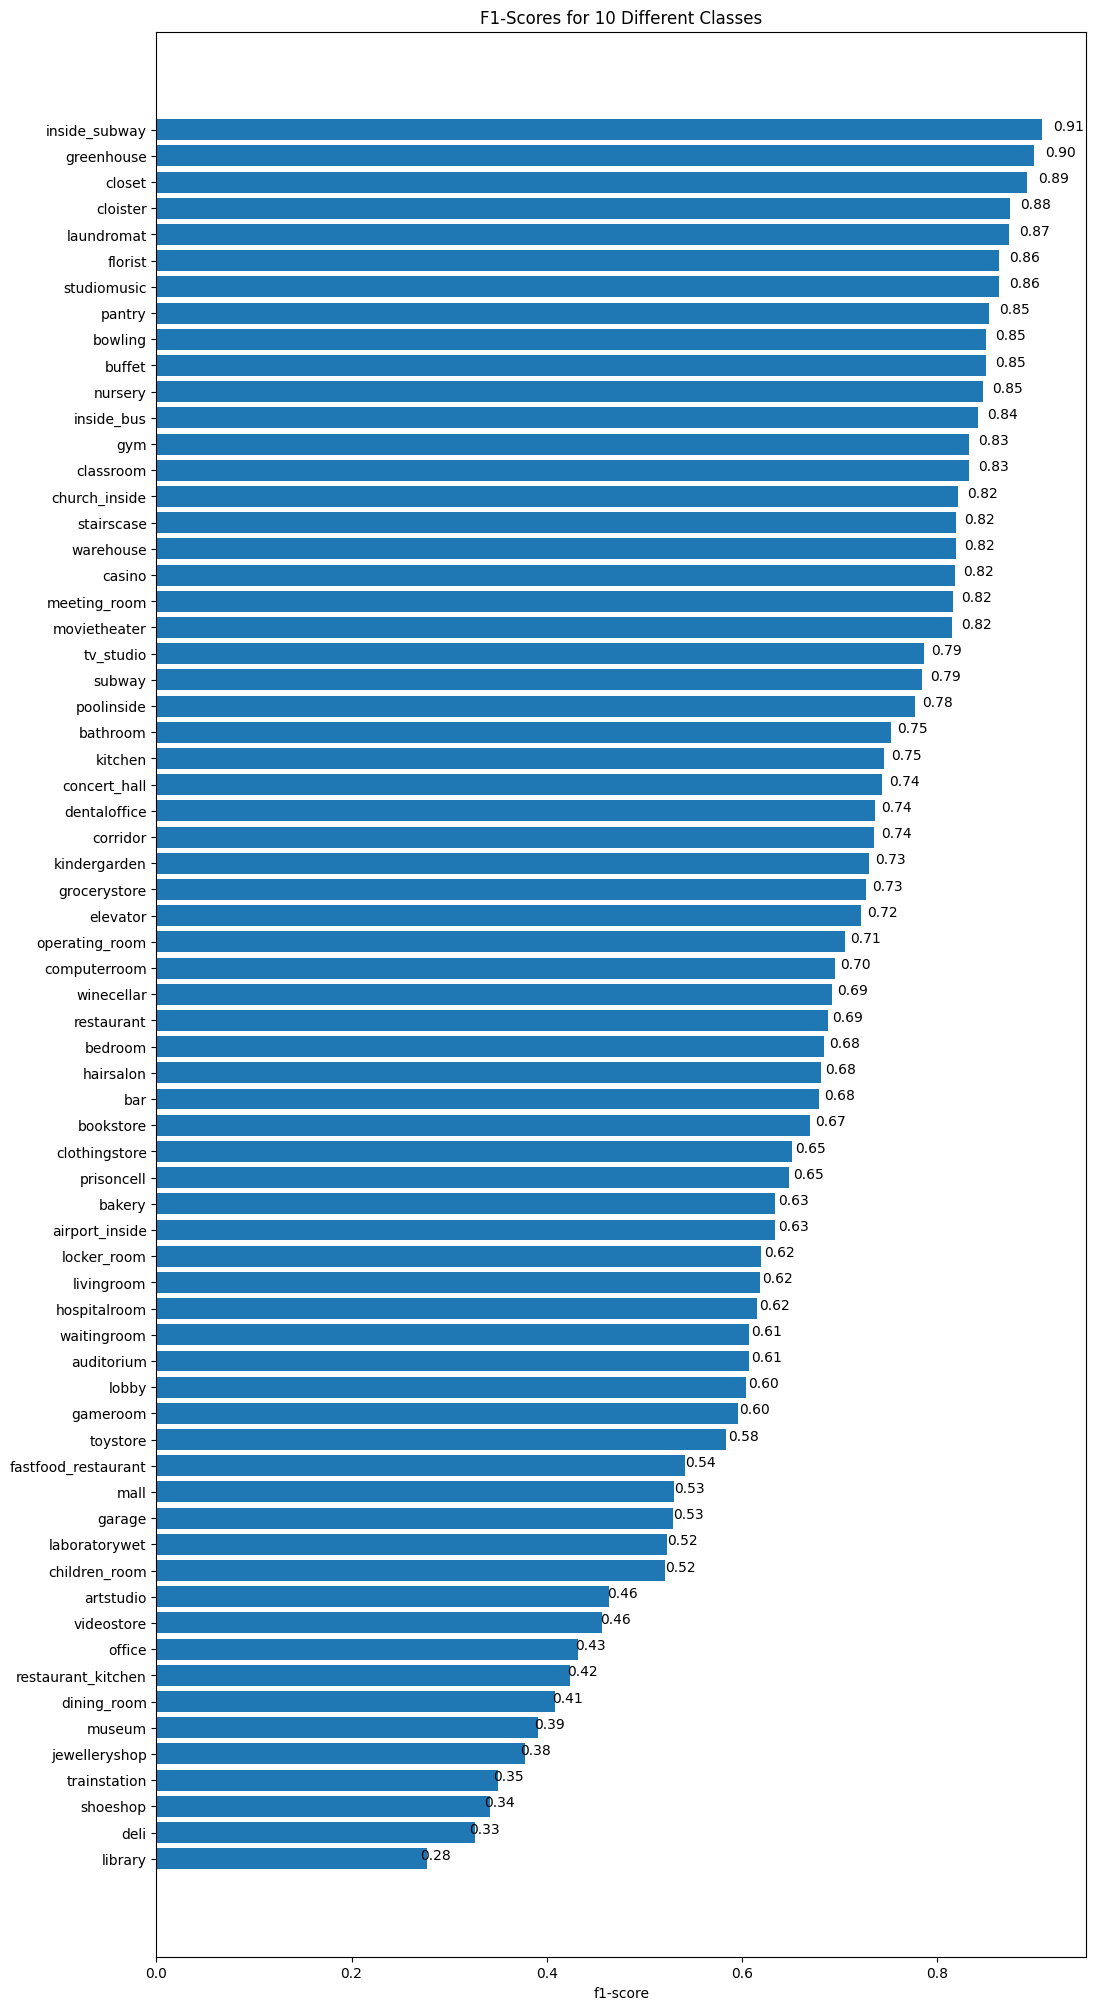

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 26ms/step


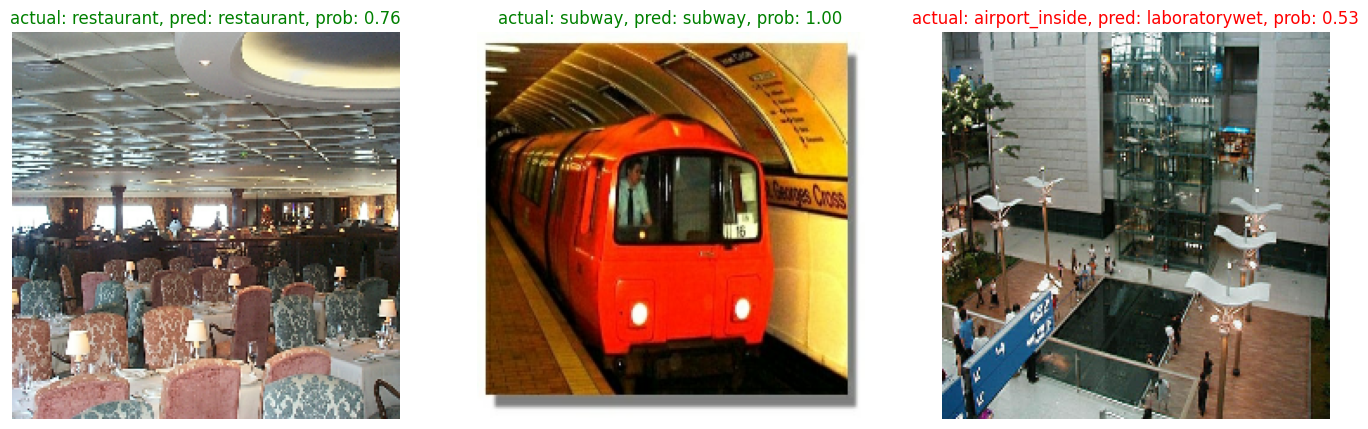

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("/content/Drive/MyDrive/my_dataset/CNN_project/test/*/*", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths

[b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0488.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0489.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0490.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0491.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0492.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0493.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0494.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0495.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0496.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/test/airport_inside/airport_inside_0497.jpg',
 b'/content/Drive/MyDrive/my_dataset/CNN_project/t

In [ ]:
# Check the lengths of the arrays
print("Length of filepaths:", len(filepaths))
print("Length of y_labels:", len(y_labels))
print("Length of pred_classes:", len(pred_classes))
print("Length of pred_probs:", len(pred_probs))
print("Length of class_names:", len(class_names))


Length of filepaths: 3144
Length of y_labels: 3144
Length of pred_classes: 3144
Length of pred_probs: 3144
Length of class_names: 67


In [59]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0       0   
1  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0      59   
2  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0      59   
3  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0       0   
4  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0      43   

   pred_conf y_true_classname y_pred_classname  
0   0.986147   airport_inside   airport_inside  
1   0.609156   airport_inside           subway  
2   0.461420   airport_inside           subway  
3   0.967554   airport_inside   airport_inside  
4   0.159629   airport_inside      locker_room

In [60]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0       0   
1  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0      59   
2  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0      59   
3  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0       0   
4  b'/content/Drive/MyDrive/my_dataset/CNN_projec...       0      43   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.986147   airport_inside   airport_inside          True  
1   0.609156   airport_inside           subway         False  
2   0.461420   airport_inside           subway         False  
3   0.967554   airport_inside   airport_inside          True  
4   0.159629   airport_inside      locker_room         False

In [61]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
1840  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      39      37   
1113  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      20       9   
174   b'/content/Drive/MyDrive/my_dataset/CNN_projec...       2      28   
958   b'/content/Drive/MyDrive/my_dataset/CNN_projec...      16      15   
2526  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      54       5   
1501  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      33      34   
1915  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      40       7   
1315  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      27      65   
2313  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      49      17   
808   b'/content/Drive/MyDrive/my_dataset/CNN_projec...      11       6   
1835  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      38       1   
1882  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      39      37   
1084  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      20      29   
813   b'/content/Drive/MyDrive/my_dataset/CNN_projec...      11      48   
2100  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      43      19   
2472  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      53       5   
1844  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      39      37   
1716  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      37      51   
175   b'/content/Drive/MyDrive/my_dataset/CNN_projec...       2      44   
2521  b'/content/Drive/MyDrive/my_dataset/CNN_projec...      54       3   

      pred_conf y_true_classname y_pred_classname  pred_correct  
1840   0.998859       laundromat          kitchen         False  
1113   0.997257             deli           buffet         False  
174    0.996945       auditorium       greenhouse         False  
958    0.994648    clothingstore           closet         False  
2526   0.994270       restaurant         bathroom         False  
1501   0.994034       inside_bus    inside_subway         False  
1915   0.991452          library        bookstore         False  
1315   0.991264           garage        warehouse         False  
2313   0.991078           office     computerroom         False  
808    0.990692    children_room          bedroom         False  
1835   0.990241    laboratorywet        artstudio         False  
1882   0.989734       laundromat          kitchen         False  
1084   0.976151             deli     grocerystore         False  
813    0.975428    children_room          nursery         False  
2100   0.971225      locker_room         corridor         False  
2472   0.971083       prisoncell         bathroom         False  
1844   0.968500       laundromat          kitchen         False  
1716   0.967377          kitchen           pantry         False  
175    0.963729       auditorium             mall         False  
2521   0.962423       restaurant           bakery         False

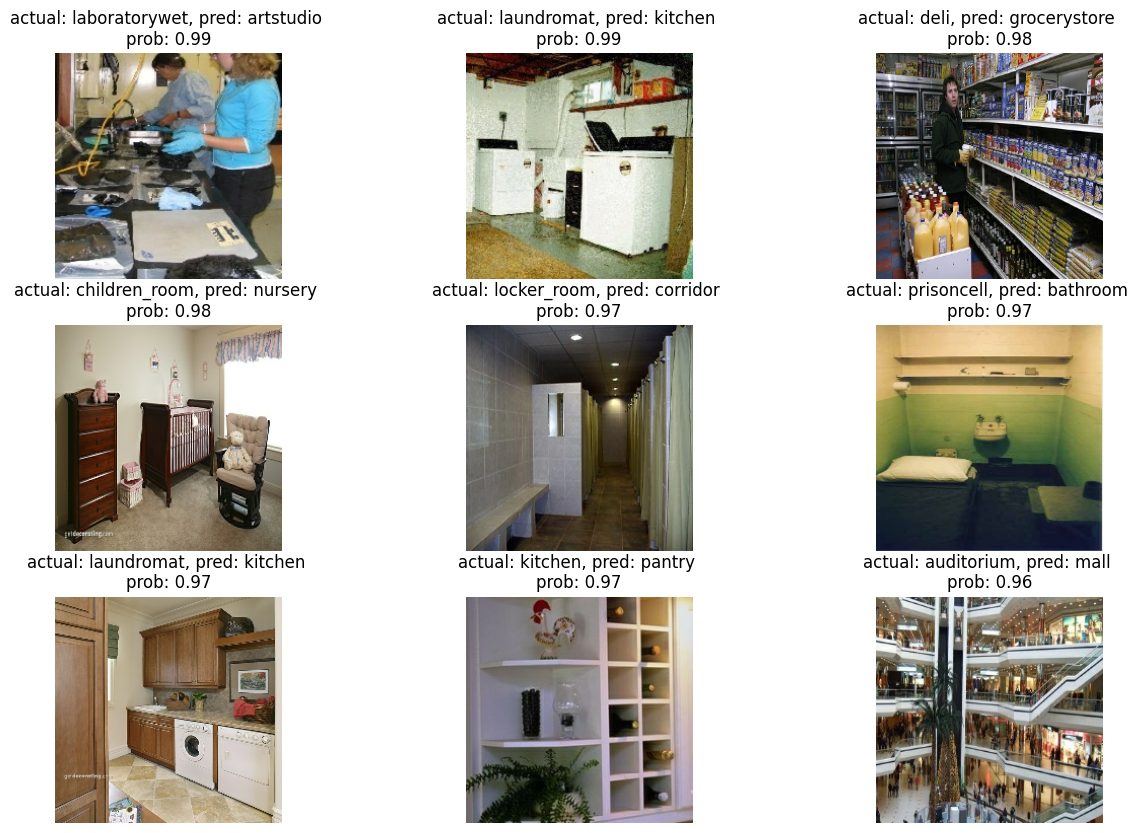

In [62]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [67]:
# Get custom food images filepaths
custom_food_images = ["/content/Drive/MyDrive/custom_data/" + img_path for img_path in os.listdir("/content/Drive/MyDrive/custom_data/")]
custom_food_images

['/content/Drive/MyDrive/custom_data/bookstore.jpeg',
 '/content/Drive/MyDrive/custom_data/buffet.jpeg',
 '/content/Drive/MyDrive/custom_data/bar.jpeg',
 '/content/Drive/MyDrive/custom_data/casino.jpeg',
 '/content/Drive/MyDrive/custom_data/classroom.jpeg',
 '/content/Drive/MyDrive/custom_data/elevator.jpeg']

/content/Drive/MyDrive/custom_data/bookstore.jpeg
1/1 [==============================] - 0s 38ms/step
/content/Drive/MyDrive/custom_data/buffet.jpeg
1/1 [==============================] - 0s 79ms/step
/content/Drive/MyDrive/custom_data/bar.jpeg
1/1 [==============================] - 0s 41ms/step
/content/Drive/MyDrive/custom_data/casino.jpeg
1/1 [==============================] - 0s 48ms/step
/content/Drive/MyDrive/custom_data/classroom.jpeg
1/1 [==============================] - 0s 72ms/step
/content/Drive/MyDrive/custom_data/elevator.jpeg
1/1 [==============================] - 0s 98ms/step


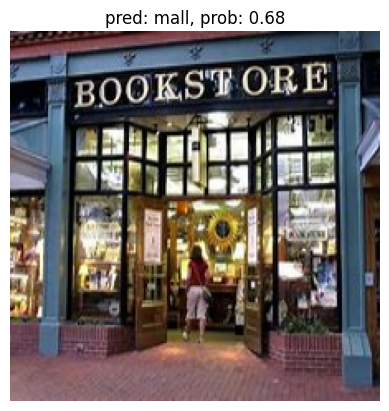

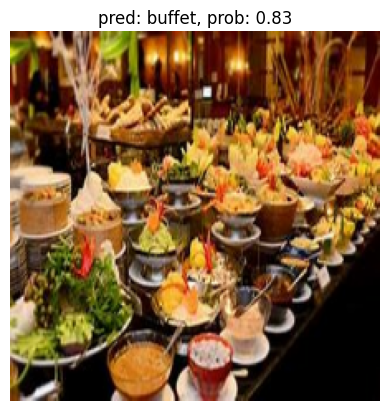

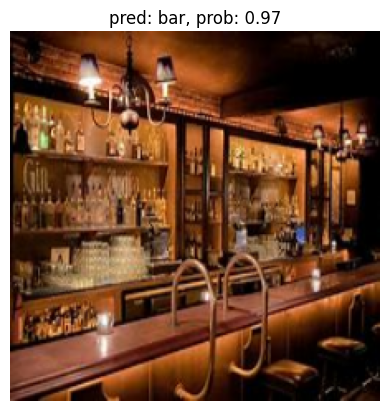

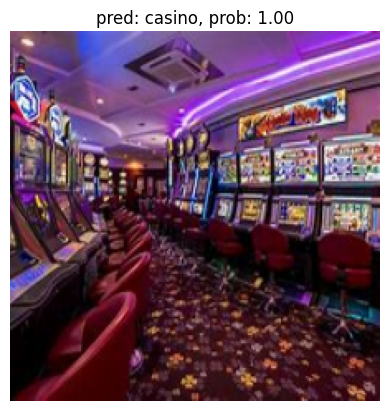

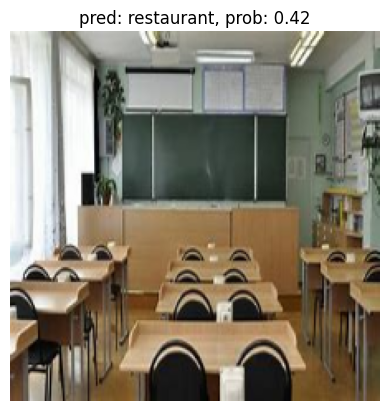

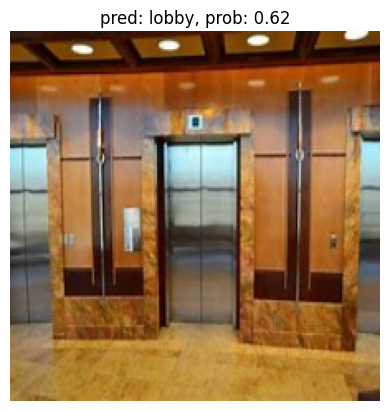

In [69]:
# Make predictions on custom food images
for img in custom_food_images:
  print(img)
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)